### This file runs the simulation of the geometry of the parabolic mirror ion trap, mainly used to simulate changes one would want to make without having to run the entire simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from numba import njit,prange

In [4]:
@njit(boundscheck=True)
def FDM_BIv03(Vrf, Vdc):
    
    #Define the parameters that make up your trap
    #For the mirror ** For now, just assume there is no hole at the bottom or holes for the slits, and mirror takes up all of lower surface **
    Hmirror = .00323; #mirror height
    Ropening = .00508; # radius at Hmirror
    #for the top endcap
    Htopcap = 0.0035; #distance from bottom of mirror to bottom of top end cap
    Ttopcap = .001; #thickness of top end cap
    PlateWidth = 0.013; #width of bias plate arms
    PlateLength = 0.01; # From center of mirror point to bias plate edge
    TGroundPlate = 0.001; #Thickness of grounded plate on top of Bias plates
    #for the needle
    Hneedle = -0.0004; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.00002; # the ball at the top of the needle to avoid fringing effects
    
    #Properties of our grid
    gmax = 0.0075 # defining the size of the world (meters)
    points = 201 # This is how many points are in your world, a higher number will have higher resolution but take longer
    steps = points - 1
    x = np.linspace(-gmax, gmax, points) # space on x-axis
    y = np.linspace(-gmax, gmax, points) # space on y-axis
    z = np.linspace(0, 2*gmax, points) # space on z-axis
    size = len(x)
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2)
    lattice_points=np.zeros((size**3,3))
    marker=0 

    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 600 #number of iterations, more precise values with higher iterations, but again, takes longer, doesn't effect anything in this document.
    CenterV = np.zeros((iterations, 1)) #keep track of the potential value at the center at each iteration
    
    
    #Now define the boundry conditions

    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                
                #Arm one of Bias plates
                if ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm Two of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm three of bias plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                #Arm four of bias plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening) and (z[k] > Htopcap) and (z[k] < (Htopcap + Ttopcap))):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                #Grounded top plate
                 #Arm one of Grounded plates
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                #Arm Two of Grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] > Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                #Arm three of grounded plate
                elif ((x[i] >= -PlateWidth/2) and (x[i] <= PlateWidth/2) and (y[j] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                #Arm four of grounded plate
                elif ((y[j] >= -PlateWidth/2) and (y[j] <= PlateWidth/2) and (x[i] < -Ropening) and (z[k] > Htopcap + Ttopcap+ 0.0002) and (z[k] < (Htopcap + Ttopcap + TGroundPlate +0.0002))):
                    V0[i, j, k] = Vrf[3]
                    V0dc[i, j, k] = Vdc[3]
                
                #The mirror
                elif ((z[k] > 0) and (z[k] < Hmirror) and (z[k] <= (Hmirror / Ropening**2) * (x[i]**2 + y[j]**2))):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                
                #The needle body
                elif ((y[j] < np.sqrt(Rneedle - x[i]**2)) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -np.sqrt(Rneedle - x[i]**2)) and (y[j] < Rneedle) and (y[j] > -Rneedle) and (z[k] > 0) and (z[k] < Hneedle)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #The needle tip
                elif ((z[k] < - np.sqrt(x[i]**2 + y[j]**2)*12.5 +0.002) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > Hneedle) and (z[k] < Hneedle + HneedleTip)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #the very tip of the needle (to avoid fringing effects)
                elif ((z[k] > 0.0019) and (z[k]< 0.0021) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2) + 0.002)):
                    V0[i, j, k] = Vrf[4]
                    V0dc[i, j, k] = Vdc[4]
                    
                #In the space with no electrodes:
                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
    lattice_points=lattice_points[0:marker]
                
    V0_temp=V0    
    V0dc_temp=V0dc
    
    return V0,V0dc,CenterV,lattice_points,cords

In [5]:
#Voltages used in the simulation
RF=np.array([0, 1, 1,1, 2]) #corresponding to each portion of the mirror geometry
DC=np.array([1, 1, 1, 1, 2])

start=time.time() # Records the time started.

A=FDM_BIv03(RF,DC) # Runs the simulation

print("The time elapsed is ",time.time()-start, "seconds")

Start Time is  1600879769.7951684
time elapsed =  5.791739225387573


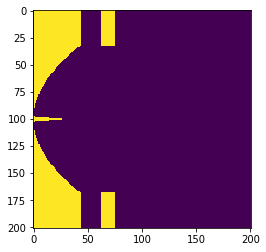

In [7]:
#Plotting the resulting geometry

plt.imshow(A[0][:,100,:], cmap=plt.cm.get_cmap('viridis', 20)) #plotting the x-z axis cross section for the RF